### Create circuit which converts a qubit register in arbitrary state to basis state |0>
Algorithm described in http://www.informatik.uni-bremen.de/agra/doc/konf/2016_ismvl_logic_synthesis_quantum_state_generation.pdf


In [9]:
import numpy as np
from numpy.random import default_rng

from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.providers.aer import Aer
from qiskit import QuantumCircuit

import math
import cmath
from math import e

%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# setup number of qubits
num_of_qubits = 5

statevec_sim = Aer.get_backend("statevector_simulator")
qasm_sim = Aer.get_backend('qasm_simulator')
unitary_sim = Aer.get_backend('unitary_simulator')

In [10]:
def random_statevector(dims, seed=None):
    """Generator a random Statevector.

    The statevector is sampled from the uniform (Haar) measure.

    Args:
        dims (int or tuple): the dimensions of the state.
        seed (int or np.random.Generator): Optional. Set a fixed seed or
                                           generator for RNG.

    Returns:
        Statevector: the random statevector.
    """
    if seed is None:
        rng = np.random.default_rng()
    elif isinstance(seed, np.random.Generator):
        rng = seed
    else:
        rng = default_rng(seed)

    dim = np.product(dims)

    # Random array over interval (0, 1]
    x = rng.random(dim)
    x += x == 0
    x = -np.log(x)
    sumx = sum(x)
    phases = rng.random(dim) * 2.0 * np.pi
    return Statevector(np.sqrt(x / sumx) * np.exp(1j * phases), dims=dims)

In [11]:
def rotation_gates(state_vector):
    n = len(state_vector)
    n1 = int(n/2)
    z_rot_angle = np.zeros(n1, dtype = float)
    y_rot_angle = np.zeros(n1, dtype = float)

    for i in range(0, n, 2):
        z_rot_angle[int(i/2)] = (cmath.phase(state_vector[i]) -
        cmath.phase(state_vector[i+1]))
        
        # Create Ry matrix
        a = cmath.polar(state_vector[i])[0]
        b = cmath.polar(state_vector[i+1])[0]
        y_rot_angle[int(i/2)] = 2.0 * np.arcsin((a - b)/math.sqrt(2.0*(a*a + b*b)))
        
    return (z_rot_angle, y_rot_angle)

In [12]:
def create_CnRZ_CnRY_gates(circ, num_q, z_angle, y_angle):
#  create control RZ & RY with multiple control qubits

    circ.ccx(1, 2, num_q)
    for i in range(0, num_q-3):
        circ.ccx(i+3, num_q+i, num_q+i+1)

    circ.crz(z_angle, 2*num_q-3, 0)
    circ.cry(y_angle, 2*num_q-3, 0)
    
    for i in range(0, num_q-3):
        circ.ccx(num_q-i-1, 2*num_q-4-i, 2*num_q-3-i)
    circ.ccx(1, 2, num_q)
    
    return (circ)


In [13]:
# Generate random one qubit state
dim_of_qubits = 2**num_of_qubits
vec = random_statevector(dim_of_qubits,0)
#print(vec)

#print(len(vec.data), vec.dim)
#for i in range(vec.dim):
    #print('polar coord. ', cmath.polar(vec.data[i]))
    #print ('module ', abs(vec.data[i]), 'phases ', cmath.phase(vec.data[i]))

statevec = np.zeros((dim_of_qubits), dtype = complex)
statevec = vec.data

In [14]:
# create circuit and initialize qubit
qc = QuantumCircuit(num_of_qubits)

# Initialize circuit with those random state vector values
lst = [*range(0, num_of_qubits)]
qc.initialize(statevec, lst) # data for initializing and list of qubits to be initialized

# create and add extra qubits for implementing CCRZ
q2 = QuantumRegister(num_of_qubits-2, name='ancillary')
qc.add_register(q2)

#qc.draw(output='mpl')

In [15]:
last_qubit_num = num_of_qubits - 1
dim1 = 2**last_qubit_num
str_len = str(last_qubit_num)
curr_qubit_num = 1             # use this qubit# for SWAP gate

for k in range(num_of_qubits):
    z_ang, y_ang = rotation_gates(statevec[0:dim_of_qubits])

    for i in range(dim1):
        # create binary string with fixed length num_of_qubits with zero padding on left
        bin_str = format(i, '0'+str_len+'b')
        for j in range(last_qubit_num):
            if bin_str[last_qubit_num-1-j] == '0':
                qc.x(j+1)
                
        qc = create_CnRZ_CnRY_gates(qc, num_of_qubits, z_ang[i], y_ang[i])
        for j in range(last_qubit_num):
            if bin_str[last_qubit_num-1-j] == '0':
                qc.x(j+1)
        qc.barrier()
        
    
    if (curr_qubit_num <= last_qubit_num):  # Swap gates
        qc.swap(0, curr_qubit_num)
        curr_qubit_num += 1
    else:
        for j in range(num_of_qubits):
            qc.h(j)

    res = execute(qc, backend = statevec_sim).result()
    statevec = res.get_statevector()
    
print('after final cycle ')
print(statevec)
for l in range(dim_of_qubits):
    print(cmath.polar(statevec[l]))


after final cycle 
[ 9.57777312e-01+2.87511078e-01j  6.36766902e-18+5.03107977e-17j
 -4.81709784e-17+7.39154126e-17j  2.94392336e-17+4.66631854e-17j
  4.47871565e-16+9.84832926e-17j -2.04081578e-17+3.98986399e-17j
  5.39121013e-17-1.19052598e-18j -8.25693329e-17-3.76919365e-17j
  4.45068229e-16+1.23678196e-16j -2.73470517e-17+5.62296972e-17j
  3.30073070e-16+5.39719283e-17j -6.84872831e-17-2.01703532e-17j
 -1.08232727e-16-2.04679847e-17j  1.72451038e-17-9.68979487e-18j
 -2.05581503e-16+2.03235497e-18j  3.73643915e-17-5.20417043e-18j
  4.80389244e-16+1.03100268e-17j -2.99443310e-16-2.11143132e-17j
  6.53036997e-18+1.10036038e-17j  1.21328512e-16-5.62508492e-18j
 -1.34692639e-17+1.06549069e-17j  4.33170214e-17-1.44219853e-17j
 -6.00689932e-17-4.06470994e-18j -9.59539887e-17-1.11268868e-17j
  1.34692639e-17+2.77555756e-17j  8.37598589e-17-4.05661204e-17j
 -1.07450725e-16+7.78072290e-18j  5.07490473e-17+1.70496033e-17j
 -9.47634627e-17+3.26621145e-17j  1.43709198e-17+2.21304907e-17j
  1.23

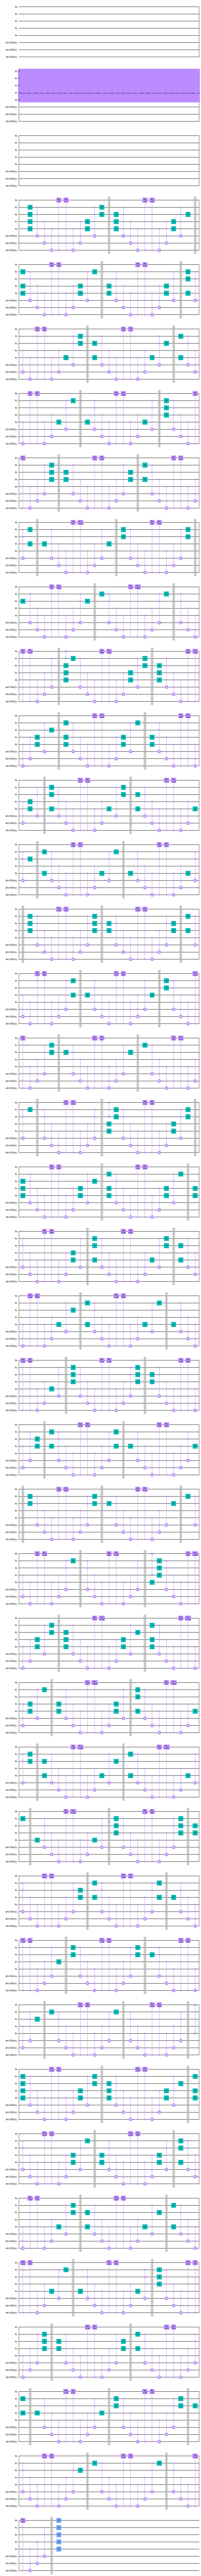

In [16]:
qc.draw(output='mpl')